In [2]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df= pd.read_csv("D:\\meais\\Documents\\Projects\\Covid\\regions_base.csv", error_bad_lines=False)
print(df.count())
df.head()

date    35
DE      35
DW      35
KE      35
KW      35
OTH     35
dtype: int64


,date,DE,DW,KE,KW,OTH
0,2/5/2020,61,43,37,24,16
1,3/5/2020,63,46,38,32,16
2,4/5/2020,68,48,41,35,21
3,5/5/2020,69,50,47,36,22
4,6/5/2020,69,50,52,40,22


Text(0.5, 1.0, 'Full Plot K&D')

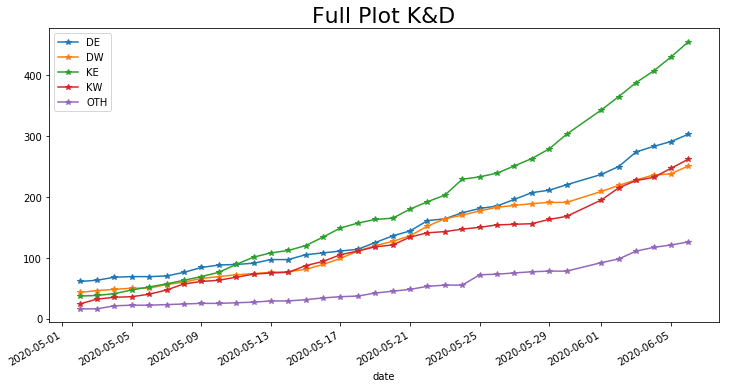

In [15]:
p=df.set_index('date') 
p.plot(marker='*',figsize=(12,6)).set_title('Full Plot K&D',fontdict={'fontsize': 22})

In [5]:
df['date']=pd.to_datetime(df['date'] , dayfirst=True, errors ='coerce')
df.head()

,date,DE,DW,KE,KW,OTH
0,2020-05-02,61,43,37,24,16
1,2020-05-03,63,46,38,32,16
2,2020-05-04,68,48,41,35,21
3,2020-05-05,69,50,47,36,22
4,2020-05-06,69,50,52,40,22


In [6]:
df.to_csv("D:\\meais\\Documents\\Projects\\Covid\\stage_1_region.csv")

In [7]:
import rpy2
%load_ext rpy2.ipython

C:\Users\meais\Anaconda3\envs\TensorFlowGPU\lib\site-packages\rpy2-2.9.4-py3.7-win-amd64.egg\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [8]:
%%R
install.packages('pracma')
install.packages('reshape')
install.packages('readr')

In [9]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("D:\\meais\\Documents\\Projects\\Covid\\stage_1_region.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]
write.csv(pred_all, "D:\\meais\\Documents\\Projects\\Covid\\kalman_result_1_region.csv")

In [10]:
p=pd.read_csv("D:\\meais\\Documents\\Projects\\Covid\\kalman_result_1_region.csv", error_bad_lines=False)
p.head()

,Unnamed: 0,Y,X,X2
0,1,61,0.000000,0.0000
1,2,63,70.694031,22.6602
2,3,68,66.762272,7.4719
3,4,69,71.738570,8.8083
4,5,69,72.954036,6.9456


In [11]:
t=df.set_index('date')
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(temp)+1):
    if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
        temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

temp.head()

,date,region,confirmed,Y,X,X2
0,2020-05-02,DE,61,61,0.000000,0.0000
1,2020-05-03,DE,63,63,70.694031,22.6602
2,2020-05-04,DE,68,68,66.762272,7.4719
3,2020-05-05,DE,69,69,71.738570,8.8083
4,2020-05-06,DE,69,69,72.954036,6.9456


In [12]:
temp.iloc[34:38,:]

,date,region,confirmed,Y,X,X2
34,2020-06-06,DE,303,303,306.075410,29.9150
35,2020-06-07,DE,0,61,317.639940,28.9069
36,2020-05-02,DW,43,43,0.000000,0.0000
37,2020-05-03,DW,46,46,49.833498,15.9736


In [13]:
temp.drop(['Y'], axis=1).to_csv("D:\\meais\\Documents\\Projects\\Covid\\kalman_final_region.csv")

Text(0.5, 1.0, 'Kalman prediction plot for DE')

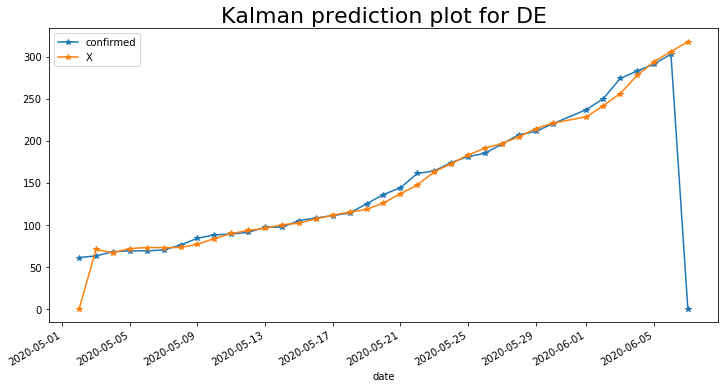

In [14]:
de = temp[temp['region']=='DE'].drop(['Y'], axis=1).set_index('date')
de.iloc[:,1:3].plot(marker='*',figsize=(12,6)).set_title('Kalman prediction plot for DE',fontdict={'fontsize': 22})

Following is the code for n-days ahead prediction:

In [16]:
t = temp.iloc[:, :3]
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])

train = t
population=1425000
train['infected_rate'] =train['last_day']/population*10000

train.to_csv("D:\\meais\\Documents\\Projects\\Covid\\train_data.csv")

train.head()

,date,region,confirmed,1_day_change,3_day_change,7_day_change,1_day_change_rate,3_day_change_rate,7_day_change_rate,last_day,kalman_prediction,infected_rate
0,2020-05-02,DE,61,0,0,0,0.000000,0.000000,0.0,0,0.0,0.000000
1,2020-05-03,DE,63,0,0,0,0.000000,0.000000,0.0,0,71.0,0.000000
2,2020-05-04,DE,68,2,0,0,3.278689,0.000000,0.0,63,67.0,0.442105
3,2020-05-05,DE,69,5,0,0,7.936508,0.000000,0.0,68,72.0,0.477193
4,2020-05-06,DE,69,1,8,0,1.470588,13.114754,0.0,69,73.0,0.484211


In [17]:
lat_long = pd.DataFrame({'region':['DE','DW','KE','KW'],
                        'latitude':[19.2161,19.2189,19.2299,19.2446],
                        'longitude':[73.0990,73.0807,73.1338,73.1235]})
lat_long

,region,latitude,longitude
0,DE,19.2161,73.0990
1,DW,19.2189,73.0807
2,KE,19.2299,73.1338
3,KW,19.2446,73.1235


In [ ]:
from weatherbit.api import Api
import json   
from pandas.io.json import json_normalize 
# api_key = "26141d374d8e49d0a2e1f1254428ce8e"
# api_key ="f206579c74644c4b96a2423cb56a1687"
api_key ="81a581ac823849f38427fb5081cb8df8"
#api_key ="be7aaf4ff7184347aa1ebc2a2db514fe"

api = Api(api_key)
api.set_granularity('daily')

w=pd.DataFrame(columns=['date','region','min','max'])
c=0
for i in range (0,len(lat_long)):
    start_date=pd.to_datetime('2020-05-02')
    for k in df['date']:
        jas=api.get_history(lat=lat_long.iloc[i,1], lon=lat_long.iloc[i,2], start_date=start_date.strftime('%Y-%m-%d'),end_date=(start_date+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')).json
      
        # j=json_normalize(j)
        # j=j['data']
        # max_temp=json_normalize(j['data'])['max_temp'].values[0] # max
        # min_temp=json_normalize(j['data'])['min_temp'].values[0]
        try:
            w=w.append({'date':k,'region':lat_long.iloc[i,0] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
        except Exception:
            w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':None,'max':None}, ignore_index=True)
        start_date=start_date+ pd.DateOffset(days=1)
        
w